#Libraries

In [77]:
import os
from os import listdir

import pandas as pd
import numpy as np
from numpy import hstack
import matplotlib.pyplot as plt
from matplotlib.image import imread
import plotly.express as px
import seaborn as sns

import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, r2_score, mean_absolute_error, accuracy_score

import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.layers import Dense, LSTM, GRU, Embedding, Flatten, Activation, Dropout
from keras import optimizers

from scipy.ndimage import shift
import glob
import PIL
import random

#Raw Data Import

In [78]:
from google.colab import drive
drive.mount('/content/drive/')

!ls /content/drive/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
MyDrive  Shareddrives


#Data Preprocessing

In [79]:
dicom_info = pd.read_csv('/content/drive/MyDrive/CIND860/csv/dicom_info.csv')
calc_case_test = pd.read_csv('/content/drive/MyDrive/CIND860/csv/calc_case_description_test_set.csv')
calc_case_train = pd.read_csv('/content/drive/MyDrive/CIND860/csv/calc_case_description_train_set.csv')
mass_case_test = pd.read_csv('/content/drive/MyDrive/CIND860/csv/mass_case_description_test_set.csv')
mass_case_train = pd.read_csv('/content/drive/MyDrive/CIND860/csv/mass_case_description_train_set.csv')
image_dir = '/content/drive/MyDrive/CIND860/jpeg'

In [80]:
dicom_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [81]:
calc_case_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               326 non-null    object
 1   breast density           326 non-null    int64 
 2   left or right breast     326 non-null    object
 3   image view               326 non-null    object
 4   abnormality id           326 non-null    int64 
 5   abnormality type         326 non-null    object
 6   calc type                322 non-null    object
 7   calc distribution        263 non-null    object
 8   assessment               326 non-null    int64 
 9   pathology                326 non-null    object
 10  subtlety                 326 non-null    int64 
 11  image file path          326 non-null    object
 12  cropped image file path  326 non-null    object
 13  ROI mask file path       326 non-null    object
dtypes: int64(4), object(10)
memory usage: 35.8

In [82]:
calc_case_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1546 non-null   object
 1   breast density           1546 non-null   int64 
 2   left or right breast     1546 non-null   object
 3   image view               1546 non-null   object
 4   abnormality id           1546 non-null   int64 
 5   abnormality type         1546 non-null   object
 6   calc type                1526 non-null   object
 7   calc distribution        1170 non-null   object
 8   assessment               1546 non-null   int64 
 9   pathology                1546 non-null   object
 10  subtlety                 1546 non-null   int64 
 11  image file path          1546 non-null   object
 12  cropped image file path  1546 non-null   object
 13  ROI mask file path       1546 non-null   object
dtypes: int64(4), object(10)
memory usage: 16

In [83]:
mass_case_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               378 non-null    object
 1   breast_density           378 non-null    int64 
 2   left or right breast     378 non-null    object
 3   image view               378 non-null    object
 4   abnormality id           378 non-null    int64 
 5   abnormality type         378 non-null    object
 6   mass shape               378 non-null    object
 7   mass margins             361 non-null    object
 8   assessment               378 non-null    int64 
 9   pathology                378 non-null    object
 10  subtlety                 378 non-null    int64 
 11  image file path          378 non-null    object
 12  cropped image file path  378 non-null    object
 13  ROI mask file path       378 non-null    object
dtypes: int64(4), object(10)
memory usage: 41.5

In [84]:
mass_case_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

In [85]:
cropped_images = dicom_info[dicom_info.SeriesDescription == 'cropped images'].image_path
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [86]:
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images.head()

0     /content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
3     /content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
6     /content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
7     /content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
10    /content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
Name: image_path, dtype: object

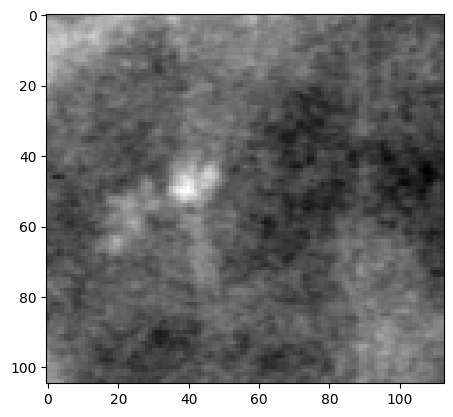

In [87]:
for file in cropped_images[0:10]:
    cropped_images_show = PIL.Image.open(file)
    gray_img= cropped_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [88]:
full_mammogram_images = dicom_info[dicom_info.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [89]:
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_mammogram_images.head()

1     /content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
2     /content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
11    /content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
12    /content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
15    /content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
Name: image_path, dtype: object

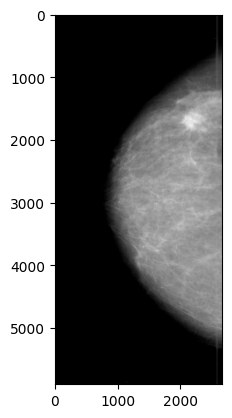

In [90]:
for file  in full_mammogram_images[0:10]:
    full_mammogram_images_show = PIL.Image.open(file)
    gray_img= full_mammogram_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [91]:
ROI_mask_images = dicom_info[dicom_info.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [92]:
ROI_mask_images = ROI_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_mask_images.head()

5     /content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
8     /content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
9     /content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
14    /content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
20    /content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
Name: image_path, dtype: object

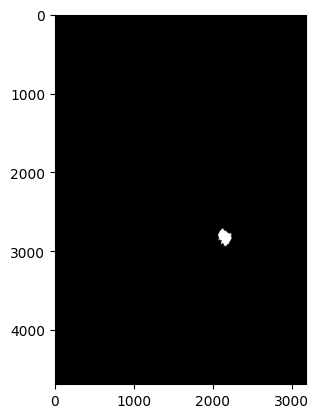

In [93]:
for file  in ROI_mask_images[0:10]:
    ROI_mask_images_show = PIL.Image.open(file)
    gray_img= ROI_mask_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

#Data Cleaning

In [94]:
dicom_info.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'],axis =1, inplace=True)

In [95]:
dicom_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   file_path                                    10237 non-null  object
 1   image_path                                   10237 non-null  object
 2   BitsAllocated                                10237 non-null  int64 
 3   BitsStored                                   10237 non-null  int64 
 4   BodyPartExamined                             10237 non-null  object
 5   ConversionType                               10237 non-null  object
 6   HighBit                                      10237 non-null  int64 
 7   LargestImagePixelValue                       10237 non-null  int64 
 8   Laterality                                   9671 non-null   object
 9   Modality                                     10237 non-null  object
 10  PatientID 

In [96]:
dicom_info.isna().sum()

file_path                                        0
image_path                                       0
BitsAllocated                                    0
BitsStored                                       0
BodyPartExamined                                 0
ConversionType                                   0
HighBit                                          0
LargestImagePixelValue                           0
Laterality                                     566
Modality                                         0
PatientID                                        0
PatientName                                      0
PatientOrientation                               0
PhotometricInterpretation                        0
PixelRepresentation                              0
SamplesPerPixel                                  0
SecondaryCaptureDeviceManufacturer               0
SecondaryCaptureDeviceManufacturerModelName      0
SeriesDescription                              566
SmallestImagePixelValue        

In [97]:
dicom_info['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)
dicom_info['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)

In [98]:
dicom_info.isna().sum()

file_path                                      0
image_path                                     0
BitsAllocated                                  0
BitsStored                                     0
BodyPartExamined                               0
ConversionType                                 0
HighBit                                        0
LargestImagePixelValue                         0
Laterality                                     0
Modality                                       0
PatientID                                      0
PatientName                                    0
PatientOrientation                             0
PhotometricInterpretation                      0
PixelRepresentation                            0
SamplesPerPixel                                0
SecondaryCaptureDeviceManufacturer             0
SecondaryCaptureDeviceManufacturerModelName    0
SeriesDescription                              0
SmallestImagePixelValue                        0
SpecificCharacterSet

In [99]:
calc_case_train = calc_case_train.rename(columns={'calc type':'calc_type'})
calc_case_train = calc_case_train.rename(columns={'calc distribution':'calc_distribution'})
calc_case_train = calc_case_train.rename(columns={'image view':'image_view'})
calc_case_train = calc_case_train.rename(columns={'left or right breast':'left_or_right_breast'})
calc_case_train = calc_case_train.rename(columns={'breast density':'breast_density'})
calc_case_train = calc_case_train.rename(columns={'abnormality type':'abnormality_type'})
calc_case_train['pathology'] = calc_case_train['pathology'].astype('category')
calc_case_train['calc_type'] = calc_case_train['calc_type'].astype('category')
calc_case_train['calc_distribution'] = calc_case_train['calc_distribution'].astype('category')
calc_case_train['abnormality_type'] = calc_case_train['abnormality_type'].astype('category')
calc_case_train['image_view'] = calc_case_train['image_view'].astype('category')
calc_case_train['left_or_right_breast'] = calc_case_train['left_or_right_breast'].astype('category')
calc_case_train.isna().sum()

patient_id                   0
breast_density               0
left_or_right_breast         0
image_view                   0
abnormality id               0
abnormality_type             0
calc_type                   20
calc_distribution          376
assessment                   0
pathology                    0
subtlety                     0
image file path              0
cropped image file path      0
ROI mask file path           0
dtype: int64

In [100]:
calc_case_train['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True)
calc_case_train['calc_distribution'].fillna(method = 'bfill', axis = 0, inplace=True)
calc_case_train.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
calc_type                  0
calc_distribution          0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [101]:
mass_case_train = mass_case_train.rename(columns={'mass shape':'mass_shape'})
mass_case_train = mass_case_train.rename(columns={'left or right breast':'left_or_right_breast'})
mass_case_train = mass_case_train.rename(columns={'mass margins':'mass_margins'})
mass_case_train = mass_case_train.rename(columns={'image view':'image_view'})
mass_case_train = mass_case_train.rename(columns={'abnormality type':'abnormality_type'})
mass_case_train['left_or_right_breast'] = mass_case_train['left_or_right_breast'].astype('category')
mass_case_train['image_view'] = mass_case_train['image_view'].astype('category')
mass_case_train['mass_margins'] = mass_case_train['mass_margins'].astype('category')
mass_case_train['mass_shape'] = mass_case_train['mass_shape'].astype('category')
mass_case_train['abnormality_type'] = mass_case_train['abnormality_type'].astype('category')
mass_case_train['pathology'] = mass_case_train['pathology'].astype('category')
mass_case_train.isna().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [102]:
mass_case_train['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True)
mass_case_train['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True)
mass_case_train.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [103]:
full_mammogram_images = dicom_info[dicom_info.SeriesDescription == 'full mammogram images'].image_path
cropped_images = dicom_info[dicom_info.SeriesDescription == 'cropped images'].image_path
roi_mask_images = dicom_info[dicom_info.SeriesDescription == 'ROI mask images'].image_path

full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
roi_mask_images = roi_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_mammogram_images.iloc[0]

'/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg'

#Data Visualization

In [104]:
mass_case = pd.DataFrame(mass_case_train['pathology'].value_counts())
mass_case = mass_case.reset_index()
mass_case = mass_case.rename(columns={'index':'pathology','pathology':'counts'})

In [105]:
fig_1a = px.bar(data_frame = mass_case, x = 'pathology', y = 'counts', color = 'pathology')
fig_1a.update_layout(title_text='Pathology of Mass Cancer Cases', title_x=0.45)
fig_1a.show()

In [106]:
fig_1b = px.pie(data_frame = mass_case, names= 'pathology', values='counts', color = 'pathology')
fig_1b.update_layout(title_text='The Percentages of Mass Cancer Cases', title_x=0.45)
fig_1b.show()

In [107]:
calc_case = pd.DataFrame(calc_case_train['pathology'].value_counts())
calc_case = calc_case.reset_index()
calc_case = calc_case.rename(columns={'index':'pathology','pathology':'counts'})

In [108]:
fig_2a = px.bar(data_frame = calc_case, x = 'pathology', y = 'counts', color = 'pathology')
fig_2a.update_layout(title_text='Pathology of Calcification Cancer Cases', title_x=0.45)
fig_2a.show()

In [109]:
fig_2b = px.pie(data_frame = calc_case, names= 'pathology', values='counts', color = 'pathology')
fig_2b.update_layout(title_text='The Percentages of Calcification Cancer Cases', title_x=0.45)
fig_2b.show()

#Preprocessing of Images

In [110]:
full_mammogram_dict = dict()
cropped_dict = dict()
roi_mask_dict = dict()

for dicom in full_mammogram_images:
    key = dicom.split("/")[6]
    full_mammogram_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[6]
    cropped_dict[key] = dicom
for dicom in roi_mask_images:
    key = dicom.split("/")[6]
    roi_mask_dict[key] = dicom
next(iter((full_mammogram_dict.items())) )

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [111]:
def fix_image_path(dataset):
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        dataset.iloc[i,11] = full_mammogram_dict[img_name]
        img_name = img[12].split("/")[2]
        dataset.iloc[i,12] = cropped_dict[img_name]
        img_name = img[13].split("/")[2]
        dataset.iloc[i,13] = roi_mask_dict[img_name]

In [112]:
mass_case_train.head(5)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [113]:
fix_image_path(mass_case_train)
fix_image_path(mass_case_test)
mass_data = mass_case_train.append(mass_case_test)
mass_data.head()

<ipython-input-113-5d9cb52cd42a>:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,patient_id,breast_density,left_or_right_breast,image_view,abnormality id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,left or right breast,image view,abnormality type,mass shape,mass margins
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,NaN,NaN,NaN,NaN,NaN
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,NaN,NaN,NaN,NaN,NaN
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,NaN,NaN,NaN,NaN,NaN
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,NaN,NaN,NaN,NaN,NaN
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,NaN,NaN,NaN,NaN,NaN


#Image Enhancement

In [114]:
def apply_clahe(image, clip_limit=2.0, grid_size=(8, 8)):
    # Convert the image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split the LAB image into L, A, and B channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE on the L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    clahe_l = clahe.apply(l)

    # Merge the CLAHE enhanced L channel with the original A and B channels
    clahe_lab = cv2.merge((clahe_l, a, b))

    # Convert the LAB image back to BGR color space
    clahe_bgr = cv2.cvtColor(clahe_lab, cv2.COLOR_LAB2BGR)

    return clahe_bgr

In [115]:
def haze_reduced_local_global(hazy_image, window_size=15, epsilon=0.001):
    # Convert the hazy image to LAB color space
    hazy_lab = cv2.cvtColor(hazy_image, cv2.COLOR_BGR2LAB)
    hazy_l, hazy_a, hazy_b = cv2.split(hazy_lab)

    # Estimate the atmospheric light
    atmospheric_light = np.max(hazy_l)

    # Calculate the dark channel of the hazy image
    hazy_dark = cv2.erode(hazy_l, cv2.getStructuringElement(cv2.MORPH_RECT, (window_size, window_size)))

    # Estimate the transmission map
    transmission_map = 1 - hazy_dark / atmospheric_light

    # Calculate the refined transmission map
    refined_transmission_map = cv2.max(transmission_map, epsilon)

    # Calculate the inverse transmission map
    inverse_transmission_map = 1 / refined_transmission_map

    # Dehaze the image
    dehazed_l = (hazy_l.astype(np.float32) - atmospheric_light) * inverse_transmission_map + atmospheric_light

    # Clip the dehazed L channel to the valid range [0, 255]
    dehazed_l = np.clip(dehazed_l, 0, 255).astype(np.uint8)

    # Merge the dehazed L channel with the original A and B channels
    dehazed_lab = cv2.merge((dehazed_l, hazy_a, hazy_b))

    # Convert the LAB image back to BGR color space
    dehazed_bgr = cv2.cvtColor(dehazed_lab, cv2.COLOR_LAB2BGR)

    return dehazed_bgr

In [116]:
def csid_caol(image_path, n_components, patch_size, iterations):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Extract patches from the image
    patches = cv2.extract_patches_2d(image, (patch_size, patch_size))

    # Reshape the patches for sparse coding
    patches = patches.reshape(patches.shape[0], -1)

    # Perform sparse coding using the Convolutional Analysis Operator Learning (CAOL) framework
    coder = SparseCoder(dictionary=np.random.randn(patch_size * patch_size, n_components), transform_algorithm='lasso_lars')
    codes = coder.transform(patches.T)

    # Reconstruct the image using the learned codes
    reconstructed_patches = np.dot(codes.T, coder.components_).reshape(-1, patch_size, patch_size)
    reconstructed_image = cv2.reconstruct_patches_2d(reconstructed_patches, (image.shape[0], image.shape[1]))

    return reconstructed_image.astype(np.uint8)

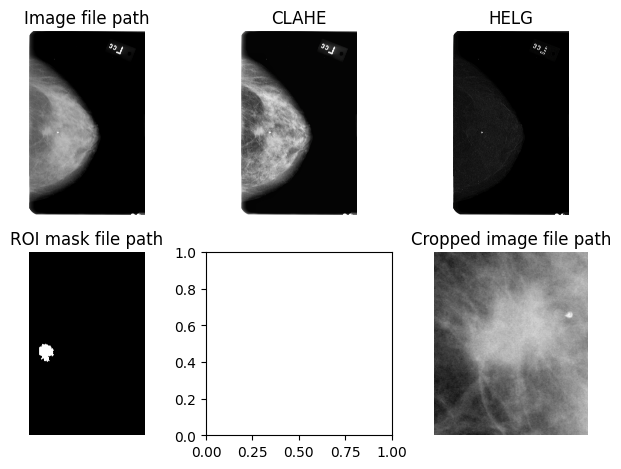

,patient_id,breast_density,left_or_right_breast,image_view,abnormality id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,left or right breast,image view,abnormality type,mass shape,mass margins
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,NaN,NaN,NaN,NaN,NaN


In [117]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read the image file
img_full = mpimg.imread(mass_data.iloc[0]['image file path'])
img_full_cv2 = cv2.imread(mass_data.iloc[0]['image file path'], cv2.IMREAD_COLOR)
img_full_clahe = apply_clahe(img_full_cv2)
img_full_helg = haze_reduced_local_global(img_full_cv2)

img_crop = mpimg.imread(mass_data.iloc[0]['cropped image file path'])
img_roi = mpimg.imread(mass_data.iloc[0]['ROI mask file path'])

# Plot the image
fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(img_full, cmap='gray')
axs[0,1].imshow(img_full_clahe, cmap='gray')
axs[0,2].imshow(img_full_helg, cmap='gray')
axs[1,0].imshow(img_roi, cmap='gray')
axs[1,2].imshow(img_crop, cmap='gray')

axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,0].axis('off')
axs[1,2].axis('off')

axs[0,0].set_title('Image file path')
axs[0,1].set_title('CLAHE')
axs[0,2].set_title('HELG')
axs[1,0].set_title('ROI mask file path')
axs[1,2].set_title('Cropped image file path')

plt.tight_layout()
# Show the plot
plt.show()
mass_data.head(1)

#Preparing the Train/Test Set

In [118]:
import time
from concurrent.futures import ThreadPoolExecutor
tf.random.set_seed(100)

#Reclassify into only 2 classifications by grouping "BENIGN_WITHOUT_CALLBACK" and "BENIGN"
classification = {"MALIGNANT": 0, "BENIGN_WITHOUT_CALLBACK": 1, "BENIGN": 1}

In [119]:
def load_image(img):
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (224, 224), interpolation = cv2.INTER_LINEAR)
    return c_img_size

def get_pathology(pathology):
    return classification[pathology]

In [120]:
def get_images_result(dataset):
    with ThreadPoolExecutor() as executor:
        images = np.array(list(executor.map(load_image, dataset.loc[:]['image file path'])))
        result = np.array(list(executor.map(get_pathology, dataset.loc[:]['pathology'])))
    result = to_categorical(result)
    return (images, result)

In [121]:
#Shuffle the train test sets
mass_train_data_shuffled = mass_case_train.sample(frac = 1)
mass_test_data_shuffled = mass_case_test.sample(frac = 1)
calc_train_data_shuffled = calc_case_train.sample(frac = 1)
calc_test_data_shuffled = calc_case_test.sample(frac = 1)

#Mass Cancer Case CNN Model VGG16

In [123]:
# Use of multi-threading to read files concurrently
tic = time.perf_counter()
(X_train, y_train) = get_images_result(mass_train_data_shuffled)
(X_test, y_test) = get_images_result(mass_test_data_shuffled)
toc = time.perf_counter()
print(f"Uploading the images and resizing in {toc - tic:0.4f} seconds")

print('X_train shape : {}' .format(X_train.shape))
print('y_train shape : {}' .format(y_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('y_test shape : {}' .format(y_test.shape))

Uploading the images and resizing in 226.9630 seconds
X_train shape : (1318, 224, 224, 3)
y_train shape : (1318, 2)
X_test shape : (378, 224, 224, 3)
y_test shape : (378, 2)


In [124]:
base_model = tf.keras.applications.vgg16.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4096, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

learningRate = 0.0001
adam_opt = tf.keras.optimizers.Adam(learning_rate = learningRate)
model.compile(optimizer = adam_opt, loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4096)              2101248   
                                                                 
 dropout_3 (Dropout)         (None, 4096)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              4195328   
                                                      

In [126]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = 64, validation_split = 0.1)

Epoch 1/100
21/21 [==============================] - 11s 385ms/step - loss: 0.9861 - accuracy: 0.5303 - val_loss: 0.7956 - val_accuracy: 0.4577
Epoch 2/100
21/21 [==============================] - 7s 319ms/step - loss: 0.8423 - accuracy: 0.5637 - val_loss: 0.7167 - val_accuracy: 0.5450
Epoch 3/100
21/21 [==============================] - 7s 328ms/step - loss: 0.7748 - accuracy: 0.5964 - val_loss: 0.6329 - val_accuracy: 0.6772
Epoch 4/100
21/21 [==============================] - 7s 328ms/step - loss: 0.7697 - accuracy: 0.5804 - val_loss: 0.6405 - val_accuracy: 0.6746
Epoch 5/100
21/21 [==============================] - 8s 383ms/step - loss: 0.7845 - accuracy: 0.5789 - val_loss: 0.6312 - val_accuracy: 0.6481
Epoch 6/100
21/21 [==============================] - 8s 391ms/step - loss: 0.7490 - accuracy: 0.6024 - val_loss: 0.6710 - val_accuracy: 0.5847
Epoch 7/100
21/21 [==============================] - 8s 392ms/step - loss: 0.7025 - accuracy: 0.6123 - val_loss: 0.6296 - val_accuracy: 0.661

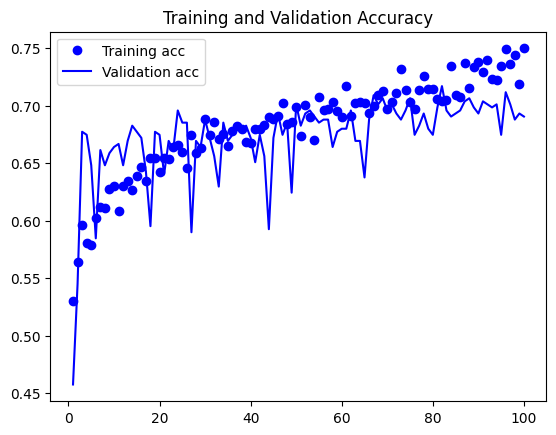

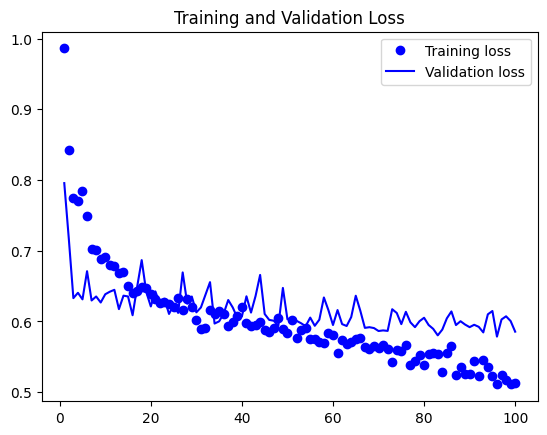

In [127]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [130]:
test_loss, test_acc = model.evaluate(X_test,y_test)
print("test_loss: %s, test_acc: %s" %(np.round(test_loss,3), np.round(test_acc,3)))

12/12 [==============================] - 2s 126ms/step - loss: 0.5855 - accuracy: 0.6905
test_loss: 0.585, test_acc: 0.69


12/12 [==============================] - 2s 127ms/step


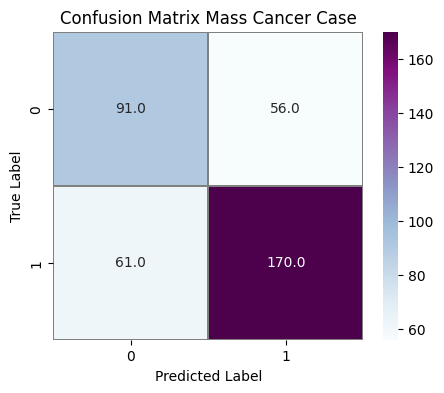

In [129]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Mass Cancer Case")
plt.show()

#Calcification Cancer Case CNN Model VGG16

In [131]:
# Use of multi-threading to read files concurrently
tic = time.perf_counter()
(X_train, y_train) = get_images_result(calc_train_data_shuffled)
(X_test, y_test) = get_images_result(calc_test_data_shuffled)
toc = time.perf_counter()
print(f"Uploading the images and resizing in {toc - tic:0.4f} seconds")

print('X_train shape : {}' .format(X_train.shape))
print('y_train shape : {}' .format(y_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('y_test shape : {}' .format(y_test.shape))

error: ignored

In [ ]:
base_model = tf.keras.applications.vgg16.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4096, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

learningRate = 0.0001
adam_opt = tf.keras.optimizers.Adam(learning_rate = learningRate)
model.compile(optimizer = adam_opt, loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Calcification Cancer Case")
plt.show()